#### Modelos e funcoes para ambos os metodos

In [2]:
from torchvision.transforms import Compose, ToTensor, Normalize

In [3]:
from tqdm.notebook import tqdm

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [34]:
import time

In [6]:
class CGAN(nn.Module):
    def __init__(self, dataset="mnist", img_size=28, latent_dim=100):
        super(CGAN, self).__init__()
        if dataset == "mnist":
            self.classes = 10
            self.channels = 1
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = nn.BCELoss()


        self.generator = nn.Sequential(
            *self._create_layer_gen(self.latent_dim + self.classes, 128, False),
            *self._create_layer_gen(128, 256),
            *self._create_layer_gen(256, 512),
            *self._create_layer_gen(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            *self._create_layer_disc(self.classes + int(np.prod(self.img_shape)), 1024, False, True),
            *self._create_layer_disc(1024, 512, True, True),
            *self._create_layer_disc(512, 256, True, True),
            *self._create_layer_disc(256, 128, False, False),
            *self._create_layer_disc(128, 1, False, False),
            nn.Sigmoid()
        )

    def _create_layer_gen(self, size_in, size_out, normalize=True):
        layers = [nn.Linear(size_in, size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def _create_layer_disc(self, size_in, size_out, drop_out=True, act_func=True):
        layers = [nn.Linear(size_in, size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, input, labels):
        if input.dim() == 2:
            z = torch.cat((self.label_embedding(labels), input), -1)
            x = self.generator(z)
            x = x.view(x.size(0), *self.img_shape) #Em
            return x
        elif input.dim() == 4:
            x = torch.cat((input.view(input.size(0), -1), self.label_embedding(labels)), -1)
            return self.discriminator(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)


In [7]:
def generate_plot(net, device, round_number, client_id = None, examples_per_class: int=5, classes: int=10, latent_dim: int=100, server: bool=False):
    """Gera plot de imagens de cada classe"""
    if server:
        import matplotlib
        matplotlib.use("Agg")
        import matplotlib.pyplot as plt
    else:
        import matplotlib.pyplot as plt

    net_type = type(net).__name__
    net.to(device)
    net.eval()
    batch_size = examples_per_class * classes

    latent_vectors = torch.randn(batch_size, latent_dim, device=device)
    labels = torch.tensor([i for i in range(classes) for _ in range(examples_per_class)], device=device)

    with torch.no_grad():
        if net_type == "Generator":
            labels_one_hot = torch.nn.functional.one_hot(labels, 10).float().to(device)
            generated_images = net(torch.cat([latent_vectors, labels_one_hot], dim=1))
        else:
            generated_images = net(latent_vectors, labels).cpu()

    # Criar uma figura com 10 linhas e 5 colunas de subplots
    fig, axes = plt.subplots(classes, examples_per_class, figsize=(5, 9))

    # Adiciona título no topo da figura
    if client_id:
        fig.text(0.5, 0.98, f"Round: {round_number} | Client: {client_id}", ha="center", fontsize=12)
    else:
        fig.text(0.5, 0.98, f"Round: {round_number}", ha="center", fontsize=12)

    # Exibir as imagens nos subplots
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i, 0, :, :], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    # Ajustar o layout antes de calcular as posições
    plt.tight_layout(rect=[0.05, 0, 1, 0.96])

    # Reduzir espaço entre colunas
    # plt.subplots_adjust(wspace=0.05)

    # Adicionar os rótulos das classes corretamente alinhados
    fig.canvas.draw()  # Atualiza a renderização para obter posições corretas
    for row in range(classes):
        # Obter posição do subplot em coordenadas da figura
        bbox = axes[row, 0].get_window_extent(fig.canvas.get_renderer())
        pos = fig.transFigure.inverted().transform([(bbox.x0, bbox.y0), (bbox.x1, bbox.y1)])
        center_y = (pos[0, 1] + pos[1, 1]) / 2  # Centro exato da linha

        # Adicionar o rótulo
        fig.text(0.04, center_y, str(row), va='center', fontsize=12, color='black')

    fig.savefig(f"mnist_CGAN_r{round_number}_f2a.png")
    plt.close(fig)
    return

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
from torch.utils.data import Dataset

class GeneratedDataset(Dataset):
    def __init__(self, generator, num_samples, latent_dim, num_classes, device):
        self.generator = generator
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.device = device
        self.model = type(self.generator).__name__
        self.images, self.labels = self.generate_data()
        self.classes = [i for i in range(self.num_classes)]


    def generate_data(self):
        self.generator.eval()
        labels = torch.tensor([i for i in range(self.num_classes) for _ in range(self.num_samples // self.num_classes)], device=self.device)
        if self.model == 'Generator':
            labels_one_hot = F.one_hot(labels, self.num_classes).float().to(self.device) #
        z = torch.randn(self.num_samples, self.latent_dim, device=self.device)
        with torch.no_grad():
            if self.model == 'Generator':
                gen_imgs = self.generator(torch.cat([z, labels_one_hot], dim=1))
            elif self.model == 'CGAN' or self.model=="F2U_GAN":
                gen_imgs = self.generator(z, labels)

        return gen_imgs.cpu(), labels.cpu()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Configurações
LATENT_DIM = 128
NUM_CHANNELS = 1
NUM_CLASSES = 10

# Camada de Convolução para o Discriminador
def conv_block(in_channels, out_channels, kernel_size=5, stride=2, padding=2, use_bn=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]
    if use_bn:
        layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

# Discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            conv_block(NUM_CHANNELS + NUM_CLASSES, 64, use_bn=False),
            conv_block(64, 128, use_bn=True),
            conv_block(128, 256, use_bn=True),
            conv_block(256, 512, use_bn=True),
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1)
        )

    def forward(self, x):
        return self.model(x)

# Camada de upsample para o Gerador
def upsample_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_bn=True):
    layers = [
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels) if use_bn else nn.Identity(),
        nn.LeakyReLU(0.2, inplace=True)
    ]
    return nn.Sequential(*layers)

# Gerador
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + NUM_CLASSES, 4 * 4 * 256),
            nn.BatchNorm1d(4 * 4 * 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (256, 4, 4)),
            upsample_block(256, 128),
            upsample_block(128, 64),
            upsample_block(64, 32),
            nn.Conv2d(32, NUM_CHANNELS, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [ ]:
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.9

# Inicializar modelos
D = Discriminator().to(device)
G = Generator(latent_dim=LATENT_DIM).to(device)
# Otimizadores
optimizer_D = torch.optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizer_G = torch.optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=5, gamma=0.9)
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=5, gamma=0.9)

 # Função de perda Wasserstein
def discriminator_loss(real_output, fake_output):
    return fake_output.mean() - real_output.mean()

def generator_loss(fake_output):
    return -fake_output.mean()

# Função para calcular Gradient Penalty
def gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolated = D(interpolated)
    gradients = torch.autograd.grad(outputs=d_interpolated, inputs=interpolated,
                                    grad_outputs=torch.ones_like(d_interpolated),
                                    create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

In [13]:
class F2U_GAN(nn.Module):
    def __init__(self, dataset="mnist", img_size=28, latent_dim=128):
        super(F2U_GAN, self).__init__()
        if dataset == "mnist":
            self.classes = 10
            self.channels = 1
        else:
            raise NotImplementedError("Only MNIST is supported")

        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        #self.label_embedding_disc = nn.Embedding(self.classes, self.img_size*self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = torch.nn.BCEWithLogitsLoss()

        # Generator (unchanged)
        self.generator = nn.Sequential(
            nn.Linear(self.latent_dim + self.label_embedding.embedding_dim, 256 * 7 * 7),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64, momentum=0.1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, self.channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        # Discriminator (corrected)
        self.discriminator = nn.Sequential(
        # Camada 1: 28x28 -> 14x14
        nn.utils.spectral_norm(nn.Conv2d(self.channels + self.classes, 32, kernel_size=4, stride=2, padding=1)),
        nn.LeakyReLU(0.2, inplace=True),

        # Camada 2: 14x14 -> 7x7
        nn.utils.spectral_norm(nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)),
        nn.LeakyReLU(0.2, inplace=True),

        # Camada 3: 7x7 -> 3x3
        nn.utils.spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
        nn.LeakyReLU(0.2, inplace=True),

        # Camada 4: 3x3 -> 1x1
        nn.utils.spectral_norm(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0)),  # Padding 0 aqui!
        nn.LeakyReLU(0.2, inplace=True),

        # Achata e concatena com as labels
        nn.Flatten(),
        nn.utils.spectral_norm(nn.Linear(256 * 1 * 1, 1))  # 256 (features) + embedding
        )

    def forward(self, input, labels):
        if input.dim() == 2:
            # Generator forward pass (unchanged)
            embedded_labels = self.label_embedding(labels)
            gen_input = torch.cat((input, embedded_labels), dim=1)
            x = self.generator(gen_input)
            return x.view(-1, *self.img_shape)

        elif input.dim() == 4:
            # Discriminator forward pass
            #features = self.discriminator[0:-1](input)  # Output shape: (batch, 256*1*1)
            embedded_labels = self.label_embedding(labels)
            image_labels = embedded_labels.view(embedded_labels.size(0), self.label_embedding.embedding_dim, 1, 1).expand(-1, -1, self.img_size, self.img_size)
            x = torch.cat((input, image_labels), dim=1)
            return self.discriminator(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)

#### Federado

In [14]:
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets import FederatedDataset

In [15]:
num_partitions = 4
alpha_dir = 0.1

In [16]:
partitioner = DirichletPartitioner(
    num_partitions=num_partitions,
    partition_by="label",
    alpha=alpha_dir,
    min_partition_size=0,
    self_balancing=False
)

In [17]:
fds = FederatedDataset(
    dataset="mnist",
    partitioners={"train": partitioner}
)

In [18]:
train_partitions = [fds.load_partition(i, split="train") for i in range(num_partitions)]

In [19]:
test_partition = fds.load_split("test")

##### Rodar proxima celula somente se quiser testar com dataset reduzido

In [20]:
num_samples = [int(len(train_partition)/10) for train_partition in train_partitions]
train_partitions = [train_partition.select(range(n)) for train_partition, n in zip(train_partitions, num_samples)]

In [21]:
pytorch_transforms = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,))
])

def apply_transforms(batch):
    batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
    return batch

In [22]:
train_partitions = [train_partition.with_transform(apply_transforms) for train_partition in train_partitions]

In [23]:
test_partition = test_partition.with_transform(apply_transforms)

In [24]:
batch_size = 128
trainloaders = [DataLoader(train_partition, batch_size=batch_size, shuffle=True) for train_partition in train_partitions]

In [54]:
testloader = DataLoader(test_partition, batch_size=batch_size)

##### CGAN

In [26]:
models = [CGAN() for i in range(num_partitions)]

##### F2U_GAN

In [62]:
models = [F2U_GAN() for i in range(num_partitions)]

##### Otimizador Disc

In [64]:
optim_Ds = [
    torch.optim.Adam(model.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    for model in models
]

##### Treinamento

In [30]:
from flwr.server.strategy.aggregate import aggregate_inplace
from flwr.common import FitRes, Status, Code, ndarrays_to_parameters
from collections import OrderedDict

In [ ]:
rounds = 2
epochs = 2

f2u_gan = True

if f2u_gan:
    latent_dim = 128
    global_net = F2U_GAN().to(device)
else:
    latent_dim = 100
    global_net = CGAN().to(device)

gera_fig = True
net_eval = True

historico_metricas = {"accuracies": [],
                      "g_losses_e": [[] for _ in range(num_partitions)],
                      "d_losses_e": [[] for _ in range(num_partitions)],
                      "g_losses_b": [[] for _ in range(num_partitions)],
                      "d_losses_b": [[] for _ in range(num_partitions)],
                      "accuracies": []}

criterion = nn.CrossEntropyLoss()

round_bar = tqdm(range(rounds), desc="Rodadas", leave=True, position=0)

for round in round_bar:
    
    print(f"\n🔸 Round {round+1}/{rounds}")

    params = []
    results = []

    client_bar = tqdm(enumerate(zip(models, trainloaders, historico_metricas["g_losses_e"], historico_metricas["d_losses_e"], historico_metricas["g_losses_b"], historico_metricas["d_losses_b"])), desc="Clientes", leave=False, position=1)
    
    for i, (model, trainloader, g_loss_e, d_loss_e, g_loss_b, d_loss_b) in client_bar:
        print(f"\n🔹 Client {i+1}/{num_partitions}")
        model.load_state_dict(global_net.state_dict(), strict=True)
        model.to(device) # move model to GPU if available
        model.train() # set model to training mode
        optim_G = torch.optim.Adam(model.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
        optim_D = torch.optim.Adam(model.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

        epoch_bar = tqdm(range(epochs), desc="Epocas locais", leave=False, position=2)

        for epoch in epoch_bar:

            print(f"\n🔹 Epoch {epoch+1}/{epochs}")

            for  batch in trainloader:
                images = batch["image"].to(device)
                labels = batch["label"].to(device)

                batch_size = images.size(0)
                if batch_size == 1:
                    print(f"Batch size is 1, skipping...")
                    continue
                real_ident = torch.full((batch_size, 1), 1., device=device)
                fake_ident = torch.full((batch_size, 1), 0., device=device)

                # Train Discriminator
                optim_D.zero_grad()

                # Real images
                y_real = model(images, labels)
                d_real_loss = model.loss(y_real, real_ident)

                # Fake images
                z_noise = torch.randn(batch_size, latent_dim, device=device)
                x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
                x_fake = model(z_noise, x_fake_labels).detach()
                y_fake_d = model(x_fake, x_fake_labels)
                d_fake_loss = model.loss(y_fake_d, fake_ident)

                #Loss calculation
                d_loss = (d_real_loss + d_fake_loss) / 2
                d_loss.backward()
                optim_D.step()
                
                # Train Generator
                optim_G.zero_grad()
                
                z_noise = torch.randn(batch_size, latent_dim, device=device)
                x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)

                x_fake = model(z_noise, x_fake_labels)

                y_fake_g = model(x_fake, x_fake_labels)

                g_loss = model.loss(y_fake_g, real_ident)
                g_loss.backward()
                optim_G.step()

                g_loss_b.append(g_loss.item())
                d_loss_b.append(d_loss.item())
            
            g_loss_e.append(np.mean(g_loss_b[epoch*len(trainloader):(epoch+1)*len(trainloader)]))
            d_loss_e.append(np.mean(d_loss_b[epoch*len(trainloader):(epoch+1)*len(trainloader)]))


            #epoch_bar.set_postfix_str(f"Client {models.index(model)+1}/{num_partitions}")
        params.append(ndarrays_to_parameters([val.cpu().numpy() for _, val in model.state_dict().items()]))
        results.append((i, FitRes(status=Status(code=Code.OK, message="Success"), parameters=params[i], num_examples=len(trainloader.dataset), metrics={})))

    # Agrega modelos

    aggregated_ndarrays = aggregate_inplace(results)
  
    params_dict = zip(global_net.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_net.load_state_dict(state_dict, strict=True)
    
    if gera_fig:
        figura = generate_plot(net=global_net, device="cpu", round_number=round, latent_dim=latent_dim)

    if net_eval:
        # Create the dataset and dataloader
        print("Gerando dados com o gerador global...")
        generated_dataset = GeneratedDataset(generator=global_net, num_samples=12000, latent_dim=latent_dim, num_classes=10, device="cpu")
        generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)
        
        print("Treinando modelo classificador")
        net = Net().to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
        net.train()
        for epoch in range(5):
            for data in generated_dataloader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        correct, loss = 0, 0.0
        net.eval()
        with torch.no_grad():
            for batch in testloader:
                images = batch["image"].to(device)
                labels = batch["label"].to(device)
                outputs = net(images)
                loss += criterion(outputs, labels).item()
                correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        accuracy = correct / len(testloader.dataset)
        print(f"Acuracia: {accuracy:.4f}")

        historico_metricas["accuracies"].append(accuracy)

##### WGAN

In [ ]:
discs = [Discriminator().to(device) for i in range(num_partitions)]
optim_Ds = [torch.optim.Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.999)) for disc in discs]

gens = [Generator().to(device) for i in range(num_partitions)]
optim_Gs = [torch.optim.Adam(gen.parameters(), lr=0.0001, betas=(0.5, 0.999)) for gen in gens]

# scheduler_Ds = [torch.optim.lr_scheduler.StepLR(optim_D, step_size=5, gamma=0.9) for optim_D in optim_Ds]

In [ ]:
rounds = 2
epochs = 2

wgan = True
latent_dim = 128
global_disc = Discriminator().to(device)
global_gen = Generator().to(device)
gp_scale = 10
gera_fig = True
net_eval = True

historico_metricas = {"accuracies": [],
                      "g_losses_e": [[] for _ in range(num_partitions)],
                      "d_losses_e": [[] for _ in range(num_partitions)],
                      "g_losses_b": [[] for _ in range(num_partitions)],
                      "d_losses_b": [[] for _ in range(num_partitions)],
                      "accuracies": []}

criterion = nn.CrossEntropyLoss()

round_bar = tqdm(range(rounds), desc="Rodadas", leave=True, position=0)

for round in round_bar:
    
    print(f"\n🔸 Round {round+1}/{rounds}")

    params = []
    results = []
    params_gen = []
    results_gen = []


    client_bar = tqdm(enumerate(zip(discs, gens, trainloaders, historico_metricas["g_losses_e"], historico_metricas["d_losses_e"], historico_metricas["g_losses_b"], historico_metricas["d_losses_b"])), desc="Clientes", leave=False, position=1)
    
    for i, (disc, gen, trainloader, g_loss_e, d_loss_e, g_loss_b, d_loss_b) in client_bar:
        print(f"\n🔹 Client {i+1}/{num_partitions}")
        disc.load_state_dict(global_disc.state_dict(), strict=True)
        disc.to(device) # move model to GPU if available
        disc.train() # set model to training mode
        optim_D = optim_Ds[i]

        gen.load_state_dict(global_gen.state_dict(), strict=True)
        gen.to(device) # move model to GPU if available
        gen.train() # set model to training mode
        optim_G = optim_Gs[i]

        epoch_bar = tqdm(range(epochs), desc="Epocas locais", leave=False, position=2)

        for epoch in epoch_bar:

            print(f"\n🔹 Epoch {epoch+1}/{epochs}")

            for  batch in trainloader:
                images = batch["image"].to(device)
                labels = batch["label"].to(device)

                batch_size = images.size(0)
                if batch_size == 1:
                    print(f"Batch size is 1, skipping...")
                    continue

                x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
                z_noise = torch.randn(batch_size, latent_dim, device=device)

                # Train Discriminator
                optim_D.zero_grad()

                labels = torch.nn.functional.one_hot(labels, 10).float().to(device)
                fake_labels = torch.nn.functional.one_hot(x_fake_labels, 10).float()

                # Adicionar labels ao real_images para treinamento do Discriminador
                image_labels = labels.view(labels.size(0), 10, 1, 1).expand(-1, -1, 28, 28)
                image_fake_labels = fake_labels.view(fake_labels.size(0), 10, 1, 1).expand(-1, -1, 28, 28)

                real_images = torch.cat([images, image_labels], dim=1)

                # Treinar Discriminador
                z = torch.cat([z_noise, fake_labels], dim=1)
                fake_images = gen(z).detach()
                fake_images = torch.cat([fake_images, image_fake_labels], dim=1)

                d_loss = discriminator_loss(disc(real_images), disc(fake_images)) + gp_scale * gradient_penalty(disc, real_images, fake_images)

                d_loss.backward()
                optim_D.step()
                
                # Train Generator
                optim_G.zero_grad()
                
                z_noise = torch.randn(batch_size, latent_dim, device=device)
                x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
                fake_labels = torch.nn.functional.one_hot(x_fake_labels, 10).float()

                z = torch.cat([z_noise, fake_labels], dim=1)

                x_fake = gen(z)

                image_fake_labels = fake_labels.view(fake_labels.size(0), 10, 1, 1).expand(-1, -1, 28, 28)

                x_fake = torch.cat([x_fake, image_fake_labels], dim=1)

                y_fake_g = disc(x_fake)

                g_loss = generator_loss(y_fake_g)

                g_loss.backward()
                optim_G.step()

                g_loss_b.append(g_loss.item())
                d_loss_b.append(d_loss.item())
            
            g_loss_e.append(np.mean(g_loss_b[epoch*len(trainloader):(epoch+1)*len(trainloader)]))
            d_loss_e.append(np.mean(d_loss_b[epoch*len(trainloader):(epoch+1)*len(trainloader)]))


            #epoch_bar.set_postfix_str(f"Client {models.index(model)+1}/{num_partitions}")
        params.append(ndarrays_to_parameters([val.cpu().numpy() for _, val in disc.state_dict().items()]))
        results.append((i, FitRes(status=Status(code=Code.OK, message="Success"), parameters=params[i], num_examples=len(trainloader.dataset), metrics={})))

        params_gen.append(ndarrays_to_parameters([val.cpu().numpy() for _, val in gen.state_dict().items()]))
        results_gen.append((i, FitRes(status=Status(code=Code.OK, message="Success"), parameters=params_gen[i], num_examples=len(trainloader.dataset), metrics={})))
    # Agrega modelos

    aggregated_ndarrays = aggregate_inplace(results)
    params_dict = zip(global_disc.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_disc.load_state_dict(state_dict, strict=True)

    aggregated_ndarrays_gen = aggregate_inplace(results_gen)
    params_dict_gen = zip(global_gen.state_dict().keys(), aggregated_ndarrays_gen)
    state_dict_gen = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict_gen})
    global_gen.load_state_dict(state_dict_gen, strict=True)
    
    if gera_fig:
        figura = generate_plot(net=global_gen, device="cpu", round_number=round, latent_dim=latent_dim)

    if net_eval:
        # Create the dataset and dataloader
        print("Gerando dados com o gerador global...")
        generated_dataset = GeneratedDataset(generator=global_gen, num_samples=12000, latent_dim=latent_dim, num_classes=10, device="cpu")
        generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)
        
        print("Treinando modelo classificador")
        net = Net().to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
        net.train()
        for epoch in range(5):
            for data in generated_dataloader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        correct, loss = 0, 0.0
        net.eval()
        with torch.no_grad():
            for batch in testloader:
                images = batch["image"].to(device)
                labels = batch["label"].to(device)
                outputs = net(images)
                loss += criterion(outputs, labels).item()
                correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        accuracy = correct / len(testloader.dataset)
        print(f"Acuracia: {accuracy:.4f}")

        historico_metricas["accuracies"].append(accuracy)

#### Centralizado

In [32]:
BATCH_SIZE = 128

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the training and test datasets
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainset_reduzido = torch.utils.data.random_split(trainset, [1000, len(trainset) - 1000])[0]
# Create data loaders
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
trainloader_reduzido = DataLoader(trainset_reduzido, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

In [33]:
model = CGAN().to(device)

In [39]:
model = F2U_GAN().to(device)

In [43]:
# Treinamento
GP_SCALE = 10
EPOCHS = 2
historico_metricas = {"d_loss_b": [], 
                      "g_loss_b": [],
                      "d_loss_e": [],
                      "g_loss_e": [],
                      "accuracy": [],
                      "time": []}   

wgan = False
f2u_gan = True

if wgan or f2u_gan:
    LATENT_DIM = 128
else:
    LATENT_DIM = 100

optim_G = torch.optim.Adam(model.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(model.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

gera_fig = True
net_eval = True

epoch_bar = tqdm(range(EPOCHS), desc="Treinamento", leave=True, position=0)

for epoch in epoch_bar:

    print(f"\n🔹 Epoch {epoch+1}/{EPOCHS}")
    G_loss = 0
    D_loss = 0
    batches = 0

    batch_bar = tqdm(trainloader_reduzido, desc="Batches", leave=False, position=1)

    start_time = time.time()
    for real_images, labels in batch_bar:
        real_images = real_images.to(device)
        labels = labels.to(device)
        batch = real_images.size(0)
        fake_labels = torch.randint(0, NUM_CLASSES, (batch,), device=device)
        z = torch.randn(batch, LATENT_DIM).to(device)
        optimizer_D.zero_grad()
        if wgan:
            labels = torch.nn.functional.one_hot(labels, NUM_CLASSES).float().to(device)
            fake_labels = torch.nn.functional.one_hot(fake_labels, NUM_CLASSES).float()

            # Adicionar labels ao real_images para treinamento do Discriminador
            image_labels = labels.view(labels.size(0), NUM_CLASSES, 1, 1).expand(-1, -1, 28, 28)
            image_fake_labels = fake_labels.view(fake_labels.size(0), NUM_CLASSES, 1, 1).expand(-1, -1, 28, 28)

            real_images = torch.cat([real_images, image_labels], dim=1)

            # Treinar Discriminador
            z = torch.cat([z, fake_labels], dim=1)
            fake_images = G(z).detach()
            fake_images = torch.cat([fake_images, image_fake_labels], dim=1)

            loss_D = discriminator_loss(D(real_images), D(fake_images)) + GP_SCALE * gradient_penalty(D, real_images, fake_images)

        else:
            real_ident = torch.full((batch, 1), 1., device=device)
            fake_ident = torch.full((batch, 1), 0., device=device)
            x_fake = model(z, fake_labels)

            y_real = model(real_images, labels)
            d_real_loss = model.loss(y_real, real_ident)
            y_fake_d = model(x_fake.detach(), fake_labels)
            d_fake_loss = model.loss(y_fake_d, fake_ident)
            loss_D = (d_real_loss + d_fake_loss) / 2

        loss_D.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # z = torch.randn(batch, LATENT_DIM).to(device)
        # z = torch.cat([z, fake_labels], dim=1)
        if wgan:
            fake_images = G(z)
            loss_G = generator_loss(D(torch.cat([fake_images, image_fake_labels], dim=1)))
        else:
            y_fake_g = model(x_fake, fake_labels)
            loss_G = model.loss(y_fake_g, real_ident)

        loss_G.backward()
        optimizer_G.step()

        G_loss += loss_G.item()
        D_loss += loss_D.item()
        historico_metricas["d_loss_b"].append(loss_D.item())
        historico_metricas["g_loss_b"].append(loss_G.item())
        batches += 1

    avg_epoch_G_loss = G_loss/batches
    avg_epoch_D_loss = D_loss/batches
    historico_metricas["d_loss_e"].append(avg_epoch_D_loss)
    historico_metricas["g_loss_e"].append(avg_epoch_G_loss)

    if gera_fig:
        # Gera plot de imagens de cada classe
        if wgan:
            figura = generate_plot(net=G, device="cpu", round_number=epoch+1, latent_dim=LATENT_DIM)
        else:
            figura = generate_plot(net=model, device="cpu", round_number=epoch+1, latent_dim=LATENT_DIM)

    if net_eval:
        # Create the dataset and dataloader
        if wgan:
            generated_dataset = GeneratedDataset(generator=G, num_samples=10000, latent_dim=LATENT_DIM, num_classes=10, device=device)
        else:
            generated_dataset = GeneratedDataset(generator=model, num_samples=10000, latent_dim=LATENT_DIM, num_classes=10, device=device)
        
        generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)

        net = Net()
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
        net.train()
        for _ in range(5):
            for data in generated_dataloader:
                inputs, labels = data
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        net.eval()
        correct, loss = 0, 0.0
        with torch.no_grad():
            for batch in testloader:
                images = batch[0]
                labels = batch[1]
                outputs = net(images)
                loss += criterion(outputs, labels).item()
                correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        accuracy = correct / len(testloader.dataset)

        end_time = time.time()
        total_time = end_time - start_time

        epoch_bar.set_postfix({
            "D_loss": f"{avg_epoch_D_loss:.4f}",
            "G_loss": f"{avg_epoch_G_loss:.4f}",
            "Acc": f"{accuracy:.4f}"
        })

        with open("Treino_GAN.txt", "a") as f:
                f.write(f"Epoca: {epoch+1}, D_loss: {avg_epoch_D_loss:.4f}, G_loss: {avg_epoch_G_loss:.4f}, Acc: {accuracy:.4f}, Tempo: {total_time:.4f}\n")

        historico_metricas["accuracy"].append(accuracy)
        historico_metricas["time"].append(total_time)

    #Atualiza o learning_rate
    scheduler_G.step()
    scheduler_D.step()
    print(f"Após Epoch {epoch+1}, LR_G: {optimizer_G.param_groups[0]['lr']:.6f}, LR_D: {optimizer_D.param_groups[0]['lr']:.6f}")
    if wgan:
         # Salvar modelo a cada época
        torch.save({"generator": G.state_dict(), "discriminator": D.state_dict()}, f"wgan_{epoch+1}e_{BATCH_SIZE}b_{LEARNING_RATE}lr.pth")
    else:
        torch.save(model.state_dict(), f"cgan_{epoch+1}e_{BATCH_SIZE}b_{LEARNING_RATE}lr.pth")

print("✅ Treinamento Concluído!")

Treinamento:   0%|          | 0/2 [00:00<?, ?it/s]


🔹 Epoch 1/2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Após Epoch 1, LR_G: 0.000180, LR_D: 0.000180

🔹 Epoch 2/2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Após Epoch 2, LR_G: 0.000162, LR_D: 0.000162
✅ Treinamento Concluído!


In [50]:
import matplotlib.pyplot as plt

def plot_line_graph(data_lists, y_label, x_label="Épocas", labels=None, highlight_max=False, highlight_min=False):
    """
    Gera um gráfico de linhas a partir de uma ou mais listas.

    Args:
        data_lists (list of lists): Listas contendo os valores para o eixo y.
        y_label (str): Título do eixo y.
        x_label (str): Título do eixo x. Padrão é "Épocas".
        labels (list of str): Rótulos para cada linha no gráfico. Padrão é None.
        highlight_max (bool): Se True, destaca o valor máximo no gráfico.
        highlight_min (bool): Se True, destaca o valor mínimo no gráfico.
    """
    for i, data in enumerate(data_lists):
        label = labels[i] if labels else None
        plt.plot(range(len(data)), data, label=label)
        
        if highlight_max:
            max_idx = data.index(max(data))
            plt.scatter(max_idx, data[max_idx], color='red', zorder=5)
            plt.text(max_idx, data[max_idx], f"Max: {data[max_idx]:.2f}", color='red', fontsize=9, ha='left', va='bottom')
        
        if highlight_min:
            min_idx = data.index(min(data))
            plt.scatter(min_idx, data[min_idx], color='blue', zorder=5)
            plt.text(min_idx, data[min_idx], f"Min: {data[min_idx]:.2f}", color='blue', fontsize=9, ha='left', va='top')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if labels:
        plt.legend()
    plt.grid(True)
    plt.show()

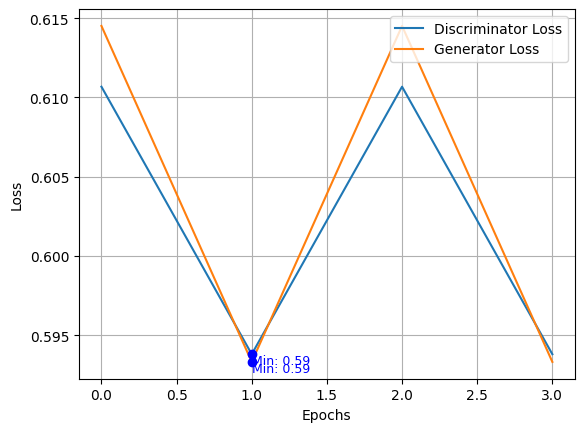

In [61]:
# Plot the discriminator and generator loss per batch
plot_line_graph(
    data_lists=[historico_metricas["g_losses_e"][2], historico_metricas["g_losses_e"][0]],
    y_label="Loss",
    x_label="Epochs",
    labels=["Discriminator Loss", "Generator Loss"],
    highlight_min=True,
)

#### Area de testes